https://github.com/parthasen/ALGO/new/LSTM

https://www.tensorflow.org/tutorials/recurrent

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
#import pandas_datareader.data as pdr_data
import numpy as np
import pandas as pd
import time
import os
import sys
from collections import deque

In [3]:
from collections import OrderedDict
import copy
#import cPickle as pkl
import random
import sys
import time
import pdb
import os
import logging

import numpy
import theano
import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.ifelse import ifelse
from theano import config

In [4]:
import tensorflow as tf
#import config as c
#from tensorflow.models.rnn import rnn
#from tensorflow.models.rnn import rnn_cell
#from tensorflow.models.rnn import seq2seq

In [27]:
! pip install config 

###### https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/lstm.py
##### https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb
##### http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

In [5]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
warnings.filterwarnings("ignore")

In [7]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)+1):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [8]:
#import lstm
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [12]:
global_start_time = time.time()
epochs  = 3
seq_len = 50
print('> Loading data... ')

X_train, y_train, X_test, y_test = load_data('/home/octo/Desktop/project_080317/SPY.csv', seq_len, True)

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(X_train,y_train,batch_size=512,nb_epoch=epochs,validation_split=0.05)

predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test) 
print('Training duration (s) : ', time.time() - global_start_time)

> Loading data... 
> Data Loaded. Compiling...
Compilation Time :  0.028746843338012695
Train on 6310 samples, validate on 333 samples
Epoch 1/3
6310/6310 [==============================] - 7s - loss: 0.0174 - val_loss: 1.0795e-07
Epoch 2/3
6310/6310 [==============================] - 7s - loss: 7.3507e-05 - val_loss: 1.3100e-06
Epoch 3/3
6310/6310 [==============================] - 7s - loss: 4.8898e-05 - val_loss: 6.4038e-08
Training duration (s) :  31.227837800979614


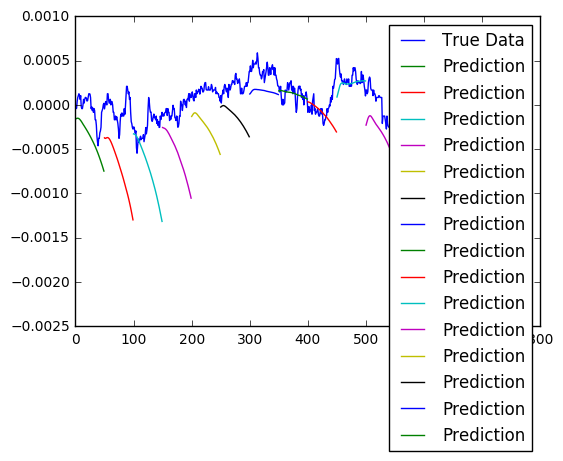

In [17]:
plot_results_multiple(predictions, y_test, 50)

https://medium.com/@TalPerry/deep-learning-the-stock-market-df853d139e02#.weu2ru2xj
https://github.com/talolard/MarketVectors/blob/master/preparedata.ipynb    

In [39]:
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
datapath = '/home/octo/Desktop/project_080317/quantquote_daily_sp500_83986/daily'
filepath = os.path.join(datapath,os.listdir('/home/octo/Desktop/project_080317/quantquote_daily_sp500_83986/daily')[0])

In [42]:
import re
ticker_regex = re.compile('.+_(?P<ticker>.+)\.csv')
get_ticker =lambda x :ticker_regex.match(x).groupdict()['ticker']
print(filepath,get_ticker(filepath))

/home/octo/Desktop/project_080317/quantquote_daily_sp500_83986/daily/table_nfx.csv nfx


In [43]:
ret = lambda x,y: log(y/x) #Log return 
zscore = lambda x:(x -x.mean())/x.std() # zscore

In [44]:
D = pd.read_csv(filepath,header=None,names=['UNK','o','h','l','c','v']) #Load the dataframe with head

In [45]:
D.head()

,UNK,o,h,l,c,v
19980102,0,11.720,11.875,11.565,11.875,152600
19980105,0,11.875,11.875,11.315,11.315,81200
19980106,0,11.190,11.220,10.065,10.405,328200
19980107,0,10.750,11.125,10.530,10.845,650400
19980108,0,10.750,10.970,10.500,10.530,51400


In [46]:
def make_inputs(filepath):
    D = pd.read_csv(filepath,header=None,names=['UNK','o','h','l','c','v']) #Load the dataframe with headers
    D.index = pd.to_datetime(D.index,format='%Y%m%d') # Set the indix to a datetime
    Res = pd.DataFrame()
    ticker = get_ticker(filepath)

    Res['c_2_o'] = zscore(ret(D.o,D.c))
    Res['h_2_o'] = zscore(ret(D.o,D.h))
    Res['l_2_o'] = zscore(ret(D.o,D.l))
    Res['c_2_h'] = zscore(ret(D.h,D.c))
    Res['h_2_l'] = zscore(ret(D.h,D.l))
    Res['c1_c0'] = ret(D.c,D.c.shift(-1)).fillna(0) #Tommorows return 
    Res['vol'] = zscore(D.v)
    Res['ticker'] = ticker
    return Res

In [47]:
Res = make_inputs(filepath)

In [50]:
Res.head() # Lets look at what we got

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol,ticker
1998-01-02,0.558193,-0.189480,0.235789,0.965902,0.361444,-0.048306,-1.075871,nfx
1998-01-05,-1.940882,-0.934880,-1.626524,-1.768433,-0.655125,-0.083843,-1.144195,nfx
1998-01-06,-2.934417,-0.782983,-4.694692,-3.302715,-3.461351,0.041418,-0.907834,nfx
1998-01-07,0.381670,1.010467,-0.156121,-0.476982,-0.964943,-0.029476,-0.599513,nfx
1998-01-08,-0.817170,0.214461,-0.307962,-1.351252,-0.445008,-0.011942,-1.172712,nfx


In [49]:
Res.corr() #Quick check to see we didn't mess it up. All values should be different, otherwise we repeated a variable

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol
c_2_o,1.000000,0.695814,0.751325,0.697501,0.086182,0.039865,-0.042077
h_2_o,0.695814,1.000000,0.304330,-0.029335,-0.553911,0.027395,0.201176
l_2_o,0.751325,0.304330,1.000000,0.742004,0.624512,0.017703,-0.251680
c_2_h,0.697501,-0.029335,0.742004,1.000000,0.672589,0.028148,-0.259278
h_2_l,0.086182,-0.553911,0.624512,0.672589,1.000000,-0.006988,-0.384923
c1_c0,0.039865,0.027395,0.017703,0.028148,-0.006988,1.000000,-0.011665
vol,-0.042077,0.201176,-0.251680,-0.259278,-0.384923,-0.011665,1.000000



### Generating the full data set

I'll iterate over each file, run the above and concat to a final df. Then we'll pivot


In [51]:
Final = pd.DataFrame()
for f in os.listdir(datapath):
    filepath = os.path.join(datapath,f)
    if filepath.endswith('.csv'):
        Res = make_inputs(filepath)
        Final = Final.append(Res)

In [52]:
Final.head()

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol,ticker
1998-01-02,0.558193,-0.189480,0.235789,0.965902,0.361444,-0.048306,-1.075871,nfx
1998-01-05,-1.940882,-0.934880,-1.626524,-1.768433,-0.655125,-0.083843,-1.144195,nfx
1998-01-06,-2.934417,-0.782983,-4.694692,-3.302715,-3.461351,0.041418,-0.907834,nfx
1998-01-07,0.381670,1.010467,-0.156121,-0.476982,-0.964943,-0.029476,-0.599513,nfx
1998-01-08,-0.817170,0.214461,-0.307962,-1.351252,-0.445008,-0.011942,-1.172712,nfx


In [53]:
pivot_columns = Final.columns[:-1]
P = Final.pivot_table(index=Final.index,columns='ticker',values=pivot_columns) # Make a pivot table from the data

In [55]:
P.head()

c_2_o                                                             \
ticker         a        aa      aapl abbv       abc       abt       ace acn   
1998-01-02   NaN -0.017649  6.991394  NaN  0.047250  1.845516 -0.601609 NaN   
1998-01-05   NaN  0.373488 -1.224062  NaN -0.160945  0.031659 -0.234577 NaN   
1998-01-06   NaN -0.718569  6.857266  NaN -1.102853 -0.473164  0.452262 NaN   
1998-01-07   NaN  0.980669 -3.007557  NaN  0.553079  0.746779  0.137372 NaN   
1998-01-08   NaN -1.828950  1.388888  NaN  0.488170 -0.221620 -0.484264 NaN   

                               ...       vol                                \
ticker           act      adbe ...        xl      xlnx       xom      xray   
1998-01-02 -0.911471 -0.375461 ... -0.676802  1.391497 -1.045626 -1.147952   
1998-01-05  2.090086  0.791331 ... -0.621025  1.019607 -0.615370 -0.556684   
1998-01-06 -1.239961  1.451409 ... -0.634169  0.020195 -0.527923 -1.131583   
1998-01-07 -0.878292 -0.534781 ... -0.616242  1.023705 -0.134130 -0.329006   
1998-01-08  1.300492  0.538778 ... -0.655003  0.645285 -0.907375 -1.066107   

                                                            
ticker           xrx xyl      yhoo       yum      zion zmh  
1998-01-02 -0.817355 NaN -0.368713 -0.678763 -0.724482 NaN  
1998-01-05 -0.757660 NaN  0.064841  0.980283 -0.735275 NaN  
1998-01-06 -0.629732 NaN  0.150071  1.697887 -0.683202 NaN  
1998-01-07 -0.504232 NaN -0.463651  0.515268 -0.635858 NaN  
1998-01-08 -0.560549 NaN -0.157777  0.235907 -0.605092 NaN  

[5 rows x 3500 columns]

In [56]:
mi = P.columns.tolist()

In [57]:
new_ind = pd.Index(e[1] +'_' + e[0] for e in mi)

In [58]:
P.columns = new_ind
P = P.sort(axis=1) # Sort by columns

In [59]:
P.head()

,a_c1_c0,a_c_2_h,a_c_2_o,a_h_2_l,a_h_2_o,a_l_2_o,a_vol,aa_c1_c0,aa_c_2_h,aa_c_2_o,...,zion_h_2_o,zion_l_2_o,zion_vol,zmh_c1_c0,zmh_c_2_h,zmh_c_2_o,zmh_h_2_l,zmh_h_2_o,zmh_l_2_o,zmh_vol
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017390,0.670259,-0.017649,...,0.246401,0.710284,-0.724482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022601,0.462520,0.373488,...,0.127875,0.710284,-0.735275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001693,-0.088471,-0.718569,...,-0.677287,-1.264514,-0.683202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042290,1.002099,0.980669,...,-0.677287,-1.175835,-0.635858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024094,-2.074267,-1.828950,...,-0.202411,-2.278200,-0.605092,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
clean_and_flat = P.dropna(1)

In [61]:
target_cols = list(filter(lambda x: 'c1_c0' in x, clean_and_flat.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, clean_and_flat.columns.values))

In [62]:
InputDF = clean_and_flat[input_cols][:3900]
TargetDF = clean_and_flat[target_cols][:3900]

In [63]:
corrs = TargetDF.corr()

In [64]:
num_stocks = len(TargetDF.columns)

In [65]:
TotalReturn = ((1-exp(TargetDF)).sum(1))/num_stocks # If i put one dollar in each stock at the close, this is how much I'd get back

In [66]:
def labeler(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [67]:
Labeled = pd.DataFrame()
Labeled['return'] = TotalReturn
Labeled['class'] = TotalReturn.apply(labeler,1)
Labeled['multi_class'] = pd.qcut(TotalReturn,11,labels=range(11))

In [68]:
pd.qcut(TotalReturn,5).unique()

[(-0.00301, 0.00119], (0.00741, 0.0999], (0.00119, 0.00741], [-0.108, -0.00877], (-0.00877, -0.00301]]
Categories (5, object): [[-0.108, -0.00877] < (-0.00877, -0.00301] < (-0.00301, 0.00119] < (0.00119, 0.00741] < (0.00741, 0.0999]]

In [69]:
def labeler_multi(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [70]:
Labeled['class'].value_counts()

 1    1301
 0    1301
-1    1298
Name: class, dtype: int64

In [71]:
Labeled['act_return'] = Labeled['class'] * Labeled['return']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f36290ab860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3629007860>], dtype=object)

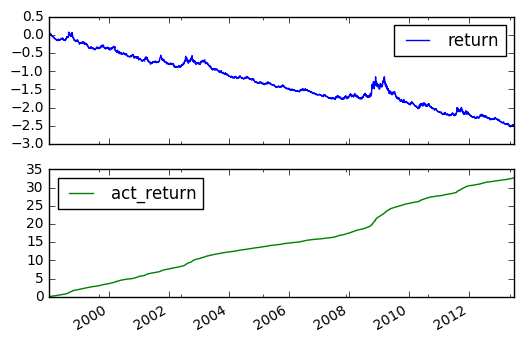

In [72]:
Labeled[['return','act_return']].cumsum().plot(subplots=True)

##### Logistic Regression

In [73]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)

In [74]:
test_size=600

In [75]:
res = logreg.fit(InputDF[:-test_size],Labeled['multi_class'][:-test_size])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
#print(classification_report(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))
print(confusion_matrix(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))